Aquí irá el portafolio de Blumenkron

#Introducción

Los incendios forestales han sido un fenómeno que ha afectado de diversas maneras a las personas al rededor del mundo

In [7]:
import os, shutil, pathlib
from keras.applications import ResNet50 #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.utils import image_dataset_from_directory #type: ignore
from keras.models import Sequential #type: ignore
from keras.callbacks import EarlyStopping #type: ignore
from keras import layers
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class_names = ["Fire","No Fire"]

base_dir = pathlib.Path("the_wildfire_dataset_2n_version")


train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=32,
   label_mode="int",
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "val",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int")

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int")


Found 1887 files belonging to 2 classes.
Found 402 files belonging to 2 classes.
Found 410 files belonging to 2 classes.


2024-11-04 17:19:08.568376: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


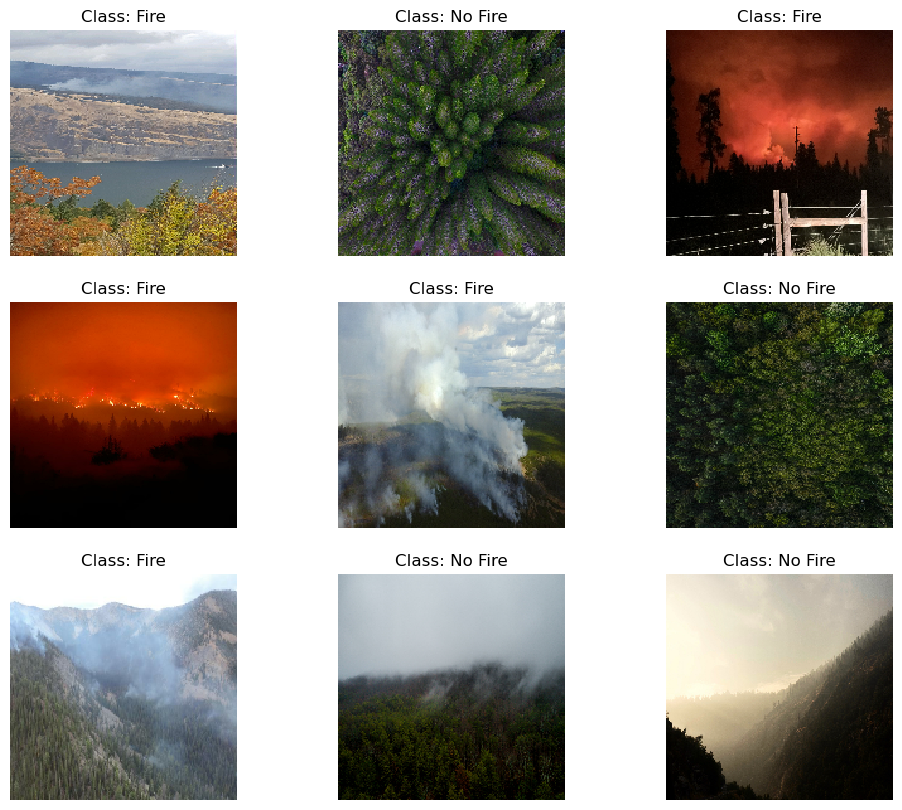

In [8]:
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Se inicializa el modelo YA NO SE PUEDE pero sin la capa de arriba, ya que nosotros queremos indicarle que clases son las que el modelo debe manejar para hacer las predicciones

In [9]:
# Crear un nuevo modelo
model_final = Sequential([
    layers.GlobalAveragePooling2D(),  # Esta capa reduce la dimensionalidad
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Cambia 1 por el número de clases que tengas
])


In [10]:
model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

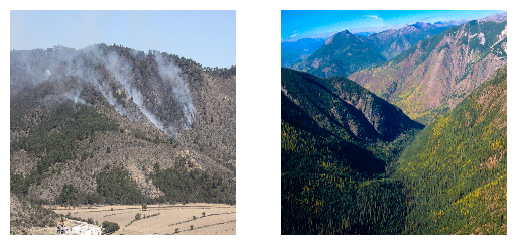

In [11]:
fire = keras.utils.load_img('the_wildfire_dataset_2n_version/test/fire/8468567365_18760a6d8b_o.jpg', target_size=(224,224))
no_fire = keras.utils.load_img('the_wildfire_dataset_2n_version/test/nofire/23289748533_1a14a0f249_o.jpg', target_size=(224,224))

fire_array = np.array(fire)
no_fire_array = np.array(no_fire)

images = np.array([fire_array, no_fire_array])

plt.subplot(121)
plt.imshow(images[0]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.imshow(images[1]/255, interpolation="nearest")
plt.axis("off")
plt.show()

In [12]:
# Configurar el callback EarlyStopping
early_stopper = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del mejor modelo al final del entrenamiento
)

# Entrenar el modelo
history = model_final.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,# Ajusta el número de épocas según sea necesario
    callbacks=[early_stopper]
)


Epoch 1/20
 3/59 ━━━━━━━━━━━━━━━━━━━━ 49s 888ms/step - accuracy: 0.6163 - loss: 4.5533

Invalid SOS parameters for sequential JPEG


15/59 ━━━━━━━━━━━━━━━━━━━━ 30s 688ms/step - accuracy: 0.5708 - loss: 4.7978

2024-11-04 17:19:20.194255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/59 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step - accuracy: 0.5589 - loss: 5.2283

2024-11-04 17:19:28.776077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


30/59 ━━━━━━━━━━━━━━━━━━━━ 19s 687ms/step - accuracy: 0.5570 - loss: 5.2705

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 47s 777ms/step - accuracy: 0.5410 - loss: 5.4828 - val_accuracy: 0.6318 - val_loss: 1.4922
Epoch 2/20
21/59 ━━━━━━━━━━━━━━━━━━━━ 23s 613ms/step - accuracy: 0.5677 - loss: 3.5460

Invalid SOS parameters for sequential JPEG


23/59 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.5655 - loss: 3.5616

2024-11-04 17:20:09.932172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


27/59 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.5633 - loss: 3.5615

Invalid SOS parameters for sequential JPEG


39/59 ━━━━━━━━━━━━━━━━━━━━ 12s 640ms/step - accuracy: 0.5558 - loss: 3.5445

2024-11-04 17:20:20.945466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


59/59 ━━━━━━━━━━━━━━━━━━━━ 47s 789ms/step - accuracy: 0.5464 - loss: 3.5444 - val_accuracy: 0.6393 - val_loss: 0.9414
Epoch 3/20
 4/59 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 0.5625 - loss: 3.4415

Invalid SOS parameters for sequential JPEG


39/59 ━━━━━━━━━━━━━━━━━━━━ 13s 656ms/step - accuracy: 0.5526 - loss: 2.7937

2024-11-04 17:21:09.079491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


42/59 ━━━━━━━━━━━━━━━━━━━━ 11s 661ms/step - accuracy: 0.5532 - loss: 2.7754

Invalid SOS parameters for sequential JPEG


57/59 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 0.5546 - loss: 2.7057

2024-11-04 17:21:21.474001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 824ms/step - accuracy: 0.5545 - loss: 2.6946 - val_accuracy: 0.6020 - val_loss: 0.7325
Epoch 4/20
13/59 ━━━━━━━━━━━━━━━━━━━━ 34s 760ms/step - accuracy: 0.6000 - loss: 1.3931

Invalid SOS parameters for sequential JPEG


22/59 ━━━━━━━━━━━━━━━━━━━━ 26s 726ms/step - accuracy: 0.5916 - loss: 1.4670

2024-11-04 17:21:47.623886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


34/59 ━━━━━━━━━━━━━━━━━━━━ 18s 720ms/step - accuracy: 0.5892 - loss: 1.4890

Invalid SOS parameters for sequential JPEG


52/59 ━━━━━━━━━━━━━━━━━━━━ 4s 711ms/step - accuracy: 0.5870 - loss: 1.4827

2024-11-04 17:22:08.920494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 866ms/step - accuracy: 0.5865 - loss: 1.4755 - val_accuracy: 0.6493 - val_loss: 0.7269
Epoch 5/20
16/59 ━━━━━━━━━━━━━━━━━━━━ 32s 745ms/step - accuracy: 0.5802 - loss: 1.2114

2024-11-04 17:22:34.484238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/59 ━━━━━━━━━━━━━━━━━━━━ 30s 779ms/step - accuracy: 0.5847 - loss: 1.1940

Invalid SOS parameters for sequential JPEG


29/59 ━━━━━━━━━━━━━━━━━━━━ 22s 740ms/step - accuracy: 0.5915 - loss: 1.1618

2024-11-04 17:22:44.554059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


45/59 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step - accuracy: 0.5928 - loss: 1.1310

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 889ms/step - accuracy: 0.5930 - loss: 1.1085 - val_accuracy: 0.6692 - val_loss: 0.5977
Epoch 6/20
12/59 ━━━━━━━━━━━━━━━━━━━━ 31s 677ms/step - accuracy: 0.6166 - loss: 0.8340

Invalid SOS parameters for sequential JPEG


25/59 ━━━━━━━━━━━━━━━━━━━━ 23s 684ms/step - accuracy: 0.6134 - loss: 0.8306

2024-11-04 17:23:33.845086: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


31/59 ━━━━━━━━━━━━━━━━━━━━ 19s 695ms/step - accuracy: 0.6135 - loss: 0.8254

2024-11-04 17:23:37.780362: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/59 ━━━━━━━━━━━━━━━━━━━━ 17s 689ms/step - accuracy: 0.6131 - loss: 0.8241

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 876ms/step - accuracy: 0.6112 - loss: 0.8166 - val_accuracy: 0.6493 - val_loss: 0.5938
Epoch 7/20
11/59 ━━━━━━━━━━━━━━━━━━━━ 36s 751ms/step - accuracy: 0.6208 - loss: 0.7074

Invalid SOS parameters for sequential JPEG


15/59 ━━━━━━━━━━━━━━━━━━━━ 33s 762ms/step - accuracy: 0.6159 - loss: 0.7186

2024-11-04 17:24:19.789785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/59 ━━━━━━━━━━━━━━━━━━━━ 29s 745ms/step - accuracy: 0.6152 - loss: 0.7227

2024-11-04 17:24:24.516173: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


28/59 ━━━━━━━━━━━━━━━━━━━━ 23s 751ms/step - accuracy: 0.6126 - loss: 0.7241

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 895ms/step - accuracy: 0.6138 - loss: 0.7215 - val_accuracy: 0.5846 - val_loss: 0.6481
Epoch 8/20
26/59 ━━━━━━━━━━━━━━━━━━━━ 22s 693ms/step - accuracy: 0.6341 - loss: 0.6733

Invalid SOS parameters for sequential JPEG


35/59 ━━━━━━━━━━━━━━━━━━━━ 16s 671ms/step - accuracy: 0.6339 - loss: 0.6755

Invalid SOS parameters for sequential JPEG


40/59 ━━━━━━━━━━━━━━━━━━━━ 12s 676ms/step - accuracy: 0.6333 - loss: 0.6763

2024-11-04 17:25:27.938405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


41/59 ━━━━━━━━━━━━━━━━━━━━ 12s 671ms/step - accuracy: 0.6332 - loss: 0.6763

2024-11-04 17:25:28.829974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 825ms/step - accuracy: 0.6300 - loss: 0.6752 - val_accuracy: 0.6020 - val_loss: 0.6017
Epoch 9/20
 4/59 ━━━━━━━━━━━━━━━━━━━━ 39s 713ms/step - accuracy: 0.6061 - loss: 0.6717

Invalid SOS parameters for sequential JPEG


17/59 ━━━━━━━━━━━━━━━━━━━━ 30s 715ms/step - accuracy: 0.6331 - loss: 0.6341

2024-11-04 17:26:01.662359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/59 ━━━━━━━━━━━━━━━━━━━━ 26s 726ms/step - accuracy: 0.6302 - loss: 0.6382

2024-11-04 17:26:05.680412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


35/59 ━━━━━━━━━━━━━━━━━━━━ 16s 696ms/step - accuracy: 0.6267 - loss: 0.6446

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 50s 849ms/step - accuracy: 0.6274 - loss: 0.6477 - val_accuracy: 0.6468 - val_loss: 0.5853
Epoch 10/20
 6/59 ━━━━━━━━━━━━━━━━━━━━ 33s 629ms/step - accuracy: 0.5781 - loss: 0.6302

Invalid SOS parameters for sequential JPEG


16/59 ━━━━━━━━━━━━━━━━━━━━ 30s 700ms/step - accuracy: 0.5913 - loss: 0.6437

2024-11-04 17:26:51.494348: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/59 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - accuracy: 0.6001 - loss: 0.6479

Invalid SOS parameters for sequential JPEG


30/59 ━━━━━━━━━━━━━━━━━━━━ 20s 696ms/step - accuracy: 0.6026 - loss: 0.6475

2024-11-04 17:27:00.910152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 830ms/step - accuracy: 0.6141 - loss: 0.6473 - val_accuracy: 0.6915 - val_loss: 0.5881
Epoch 11/20
 6/59 ━━━━━━━━━━━━━━━━━━━━ 51s 979ms/step - accuracy: 0.6780 - loss: 0.6021

Invalid SOS parameters for sequential JPEG


19/59 ━━━━━━━━━━━━━━━━━━━━ 33s 840ms/step - accuracy: 0.6508 - loss: 0.6157

2024-11-04 17:27:45.008428: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/59 ━━━━━━━━━━━━━━━━━━━━ 29s 817ms/step - accuracy: 0.6459 - loss: 0.6188

2024-11-04 17:27:47.904389: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


27/59 ━━━━━━━━━━━━━━━━━━━━ 25s 797ms/step - accuracy: 0.6440 - loss: 0.6199

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 56s 949ms/step - accuracy: 0.6418 - loss: 0.6204 - val_accuracy: 0.6766 - val_loss: 0.5787
Epoch 12/20
15/59 ━━━━━━━━━━━━━━━━━━━━ 31s 720ms/step - accuracy: 0.6756 - loss: 0.5985

Invalid SOS parameters for sequential JPEG
2024-11-04 17:28:36.723216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/59 ━━━━━━━━━━━━━━━━━━━━ 24s 738ms/step - accuracy: 0.6726 - loss: 0.6070

Invalid SOS parameters for sequential JPEG


33/59 ━━━━━━━━━━━━━━━━━━━━ 19s 739ms/step - accuracy: 0.6720 - loss: 0.6120

2024-11-04 17:28:50.272179: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 916ms/step - accuracy: 0.6684 - loss: 0.6211 - val_accuracy: 0.6642 - val_loss: 0.5750
Epoch 13/20
11/59 ━━━━━━━━━━━━━━━━━━━━ 37s 784ms/step - accuracy: 0.6657 - loss: 0.6038

Invalid SOS parameters for sequential JPEG


18/59 ━━━━━━━━━━━━━━━━━━━━ 33s 813ms/step - accuracy: 0.6603 - loss: 0.6092

2024-11-04 17:29:34.578846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/59 ━━━━━━━━━━━━━━━━━━━━ 26s 803ms/step - accuracy: 0.6577 - loss: 0.6118

2024-11-04 17:29:41.462114: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


32/59 ━━━━━━━━━━━━━━━━━━━━ 21s 792ms/step - accuracy: 0.6559 - loss: 0.6125

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 914ms/step - accuracy: 0.6493 - loss: 0.6171 - val_accuracy: 0.6891 - val_loss: 0.5834
Epoch 14/20
 6/59 ━━━━━━━━━━━━━━━━━━━━ 41s 792ms/step - accuracy: 0.6730 - loss: 0.5999

Invalid SOS parameters for sequential JPEG


18/59 ━━━━━━━━━━━━━━━━━━━━ 31s 763ms/step - accuracy: 0.6674 - loss: 0.6079

2024-11-04 17:30:27.669680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/59 ━━━━━━━━━━━━━━━━━━━━ 23s 742ms/step - accuracy: 0.6672 - loss: 0.6116

2024-11-04 17:30:34.636800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


29/59 ━━━━━━━━━━━━━━━━━━━━ 22s 740ms/step - accuracy: 0.6676 - loss: 0.6114

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 887ms/step - accuracy: 0.6690 - loss: 0.6113 - val_accuracy: 0.6791 - val_loss: 0.5691
Epoch 15/20
 6/59 ━━━━━━━━━━━━━━━━━━━━ 38s 730ms/step - accuracy: 0.6526 - loss: 0.5931

Invalid SOS parameters for sequential JPEG


18/59 ━━━━━━━━━━━━━━━━━━━━ 30s 749ms/step - accuracy: 0.6335 - loss: 0.6035

2024-11-04 17:31:20.153448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/59 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.6371 - loss: 0.6059

2024-11-04 17:31:26.394492: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


38/59 ━━━━━━━━━━━━━━━━━━━━ 15s 736ms/step - accuracy: 0.6399 - loss: 0.6084

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 904ms/step - accuracy: 0.6407 - loss: 0.6117 - val_accuracy: 0.6567 - val_loss: 0.5805
Epoch 16/20
 8/59 ━━━━━━━━━━━━━━━━━━━━ 37s 744ms/step - accuracy: 0.6030 - loss: 0.6070

Invalid SOS parameters for sequential JPEG


16/59 ━━━━━━━━━━━━━━━━━━━━ 30s 717ms/step - accuracy: 0.6138 - loss: 0.6100

2024-11-04 17:32:12.425777: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/59 ━━━━━━━━━━━━━━━━━━━━ 24s 733ms/step - accuracy: 0.6209 - loss: 0.6095

2024-11-04 17:32:18.817932: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


29/59 ━━━━━━━━━━━━━━━━━━━━ 22s 738ms/step - accuracy: 0.6228 - loss: 0.6093

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 893ms/step - accuracy: 0.6348 - loss: 0.6082 - val_accuracy: 0.6716 - val_loss: 0.5780
Epoch 17/20
15/59 ━━━━━━━━━━━━━━━━━━━━ 33s 759ms/step - accuracy: 0.6453 - loss: 0.5961

Invalid SOS parameters for sequential JPEG


17/59 ━━━━━━━━━━━━━━━━━━━━ 31s 761ms/step - accuracy: 0.6476 - loss: 0.5962

2024-11-04 17:33:05.512590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/59 ━━━━━━━━━━━━━━━━━━━━ 25s 739ms/step - accuracy: 0.6502 - loss: 0.5979

2024-11-04 17:33:11.413016: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


48/59 ━━━━━━━━━━━━━━━━━━━━ 8s 728ms/step - accuracy: 0.6572 - loss: 0.5957

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 892ms/step - accuracy: 0.6580 - loss: 0.5957 - val_accuracy: 0.6716 - val_loss: 0.5672
Epoch 18/20
 3/59 ━━━━━━━━━━━━━━━━━━━━ 46s 828ms/step - accuracy: 0.7049 - loss: 0.5384

Invalid SOS parameters for sequential JPEG


19/59 ━━━━━━━━━━━━━━━━━━━━ 28s 718ms/step - accuracy: 0.6741 - loss: 0.5846

2024-11-04 17:33:59.524408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


30/59 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.6690 - loss: 0.5947

2024-11-04 17:34:07.676107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


32/59 ━━━━━━━━━━━━━━━━━━━━ 19s 712ms/step - accuracy: 0.6686 - loss: 0.5954

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 886ms/step - accuracy: 0.6663 - loss: 0.5994 - val_accuracy: 0.6841 - val_loss: 0.5793
Epoch 19/20
 4/59 ━━━━━━━━━━━━━━━━━━━━ 42s 780ms/step - accuracy: 0.5703 - loss: 0.5683

Invalid SOS parameters for sequential JPEG


22/59 ━━━━━━━━━━━━━━━━━━━━ 28s 760ms/step - accuracy: 0.6024 - loss: 0.6046

2024-11-04 17:34:55.728364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/59 ━━━━━━━━━━━━━━━━━━━━ 26s 815ms/step - accuracy: 0.6072 - loss: 0.6057

2024-11-04 17:34:59.181047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


31/59 ━━━━━━━━━━━━━━━━━━━━ 22s 788ms/step - accuracy: 0.6129 - loss: 0.6059

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 927ms/step - accuracy: 0.6280 - loss: 0.6060 - val_accuracy: 0.6940 - val_loss: 0.5717
Epoch 20/20
 9/59 ━━━━━━━━━━━━━━━━━━━━ 39s 799ms/step - accuracy: 0.6410 - loss: 0.5971

Invalid SOS parameters for sequential JPEG


22/59 ━━━━━━━━━━━━━━━━━━━━ 28s 771ms/step - accuracy: 0.6422 - loss: 0.5891

2024-11-04 17:35:50.002164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ProPhoto RGB': 0h: PCS illuminant is not D50


26/59 ━━━━━━━━━━━━━━━━━━━━ 27s 819ms/step - accuracy: 0.6423 - loss: 0.5885

2024-11-04 17:35:54.018277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/59 ━━━━━━━━━━━━━━━━━━━━ 20s 796ms/step - accuracy: 0.6419 - loss: 0.5894

Invalid SOS parameters for sequential JPEG


59/59 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.6425 - loss: 0.5918 - val_accuracy: 0.6617 - val_loss: 0.5774


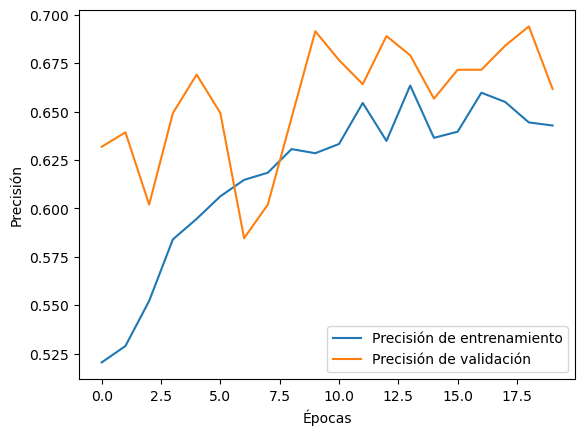

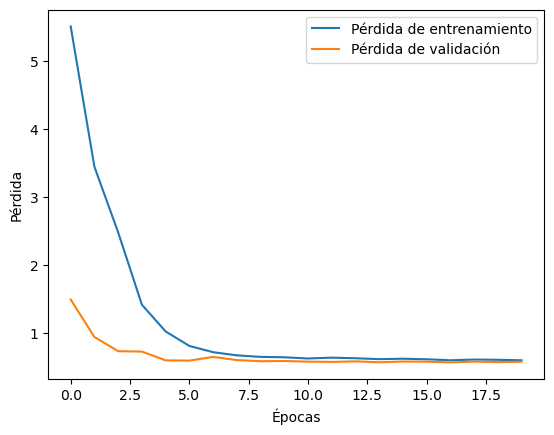

In [13]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [14]:
# Hacer predicciones en el conjunto de prueba
predictions = model_final.predict(test_dataset)

# Las predicciones son probabilidades, puedes convertirlas a clases
predicted_classes = (predictions > 0.5).astype(int) 

13/13 ━━━━━━━━━━━━━━━━━━━━ 886s 74s/step


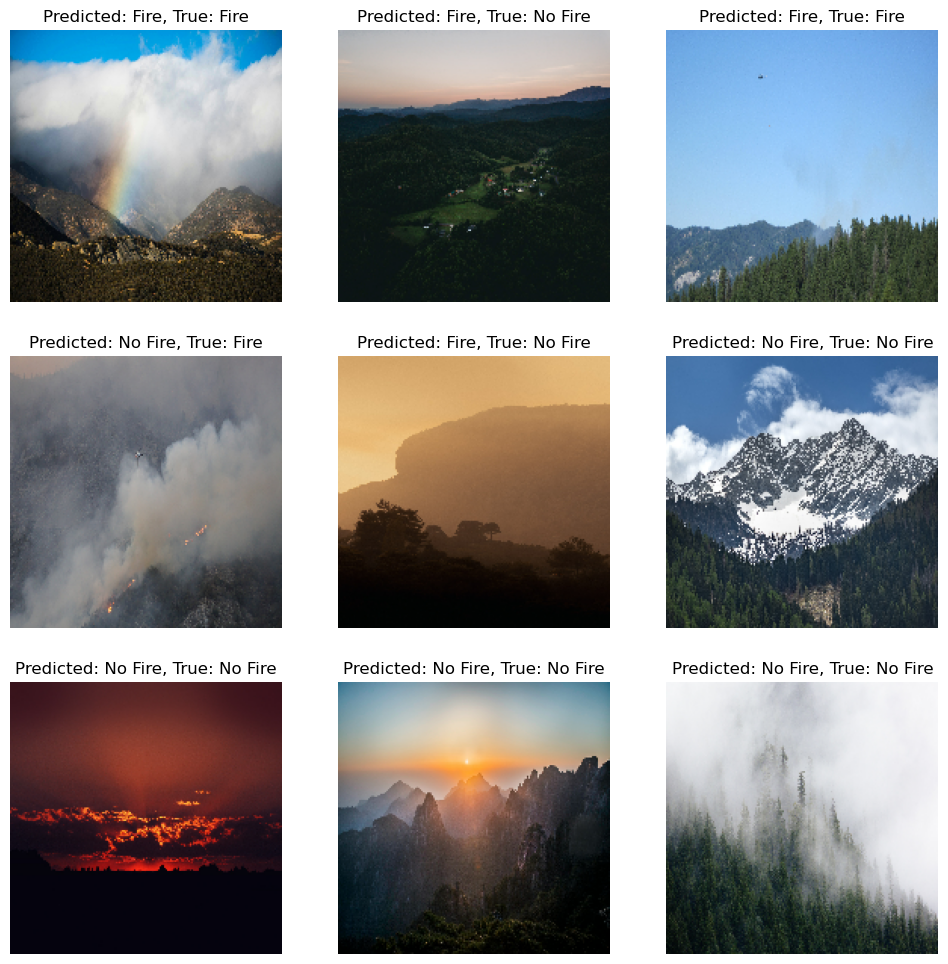

In [15]:
import matplotlib.pyplot as plt

# Función para visualizar imágenes y sus predicciones
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Predicted: {class_names[predicted_classes[i][0]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)


In [16]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model_final.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 911s 76s/step - accuracy: 0.6697 - loss: 0.5818
Test Loss: 0.5805085897445679, Test Accuracy: 0.6658536791801453
